## Welcome to on road lane detection program

Programm has image processing pipeline that support both RGB images and BGR video input.
    
    RGB image processing consists of next steps:
        - image file reading. File expected to exist on disk
        - RGB to BGR conversion
        - common image processing pipeline
        - processing result conversion (BGR to RGB)
        - result image output
    BGR video processing consists of next steps:
        - video file capturing. File expected to exist on disk
        - video frame processing loop:
            * common image processing pipeline
            * result frame output
        - resources release

    Image processing pipeline does:
        - BGR to HSV conversion
        - white and yellow colors filter, creates b/w image. Makes other colored objects black
        - detection area filter. It cuts not needed area from color filter binary image output
        - edge detection
        - lines detetection with help of Hough transform method
        - detected lines are put on initial BGR video frame
        - result image returned to program for output/further operations
        
Colors detection on HSV image allows efficientely get rid of noise coused by shadows and road surface color artifacts. Further binary image processing might save processor time.

As the next improvement I would extract configuration parametes into separate entity. And would use same instance of it for on-flight configuration/adjustment. It can become an interface for another system :)
        

Imports, compose full file path fuction

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas
import os

def getPathFor(file_path):
    current_directory = %pwd
    path = os.path.join(current_directory, file_path)
    
    print("About to open file: {}\n".format(path))
    return path



Next class is responsible for filtering out lanes detection area:

In [2]:
class DetectionAreaFilter:

    def __init__(self):
        self._lower_yellow = np.array([20, 0, 170], dtype=np.uint8)
        self._upper_yellow = np.array([55, 255, 255], dtype=np.uint8)

        self._lower_white = np.array([0, 0, 220], dtype=np.uint8)
        self._upper_white = np.array([255, 25, 255], dtype=np.uint8)

        self._ignore_mask_color = 255

    def getColorMask(self, hsv_image):
        mask_yellow = cv2.inRange(hsv_image, self._lower_yellow, self._upper_yellow)
        mask_white = cv2.inRange(hsv_image, self._lower_white, self._upper_white)

        mask = cv2.add(mask_white, mask_yellow)
        return mask

    def applyDetectionArea(self, bw_image, width_adjustment=60, height_adjustment=65):
        im_height = bw_image.shape[0]
        im_half_height = im_height // 2
        im_width = bw_image.shape[1]
        im_half_width = im_width // 2

        area_left_bottom = (0, im_height)
        area_left_top = (im_half_width - width_adjustment, im_half_height + height_adjustment)
        area_right_top = (im_half_width + width_adjustment, im_half_height + height_adjustment)
        area_right_bottom = (im_width, im_height)

        detection_area = [area_left_bottom, area_left_top, area_right_top, area_right_bottom]
        vertices = np.array([detection_area], dtype=np.int32)

        mask = np.zeros_like(bw_image)
        cv2.fillPoly(mask, vertices, self._ignore_mask_color)

        masked_image = cv2.bitwise_and(bw_image, mask)
        return masked_image


Here is the result of getColorMask function, that turns all white and yellow objects into white ones and makes  other colored objects black:

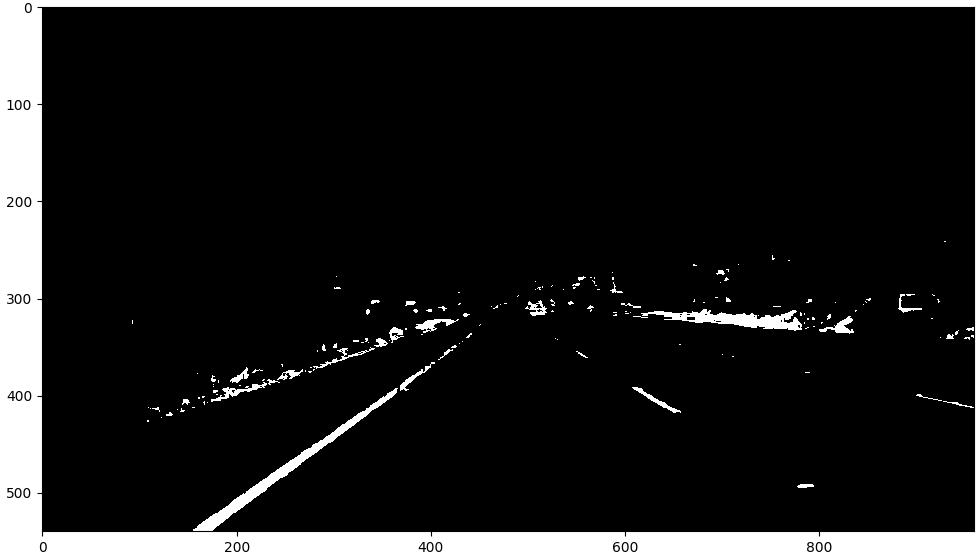

And the result of applyDetectionArea function, that creates new b/w image with applyed trapezium shaped mask out of given b/w image:

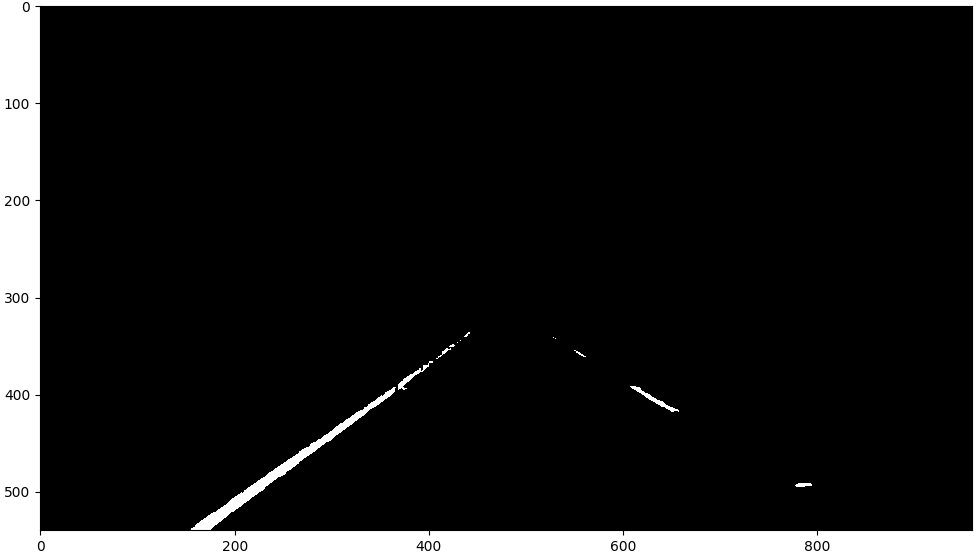

Then goes Canny edge detection:

In [3]:
def getEdges(image, low_threshold=50, high_threshold=150):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

The result of Canny edge detection:

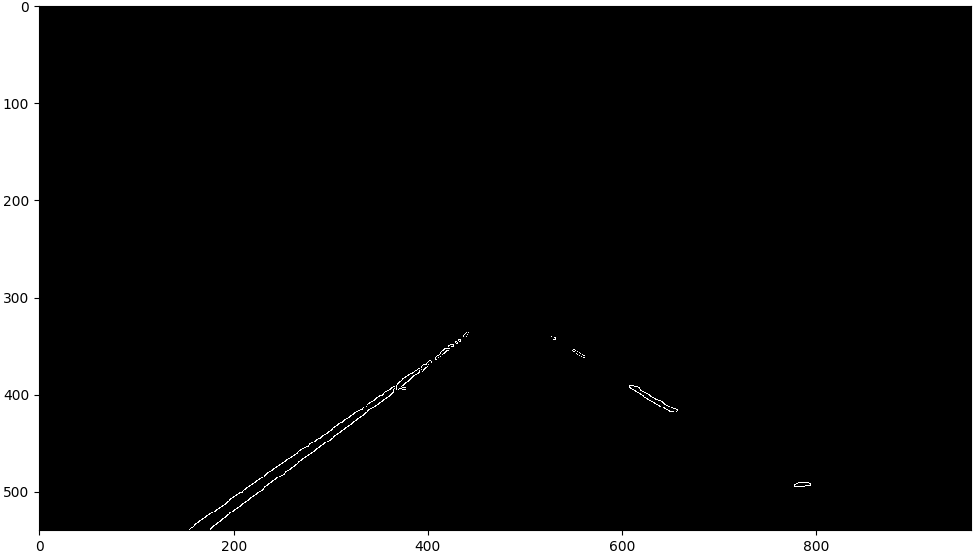

Lines detetection with help of Hough transform method

In [4]:
def getLaneLines(edges):
    deg = np.pi/180
    lines = cv2.HoughLines(edges, 1, 1*deg, 40)

    if lines is None:
        return np.array([])

    points_array = list()
    for line in lines:
        for rho, theta in line:
            points_array.append((rho, theta))

    return np.array(points_array)

Result of getLaneLines transformed into lines

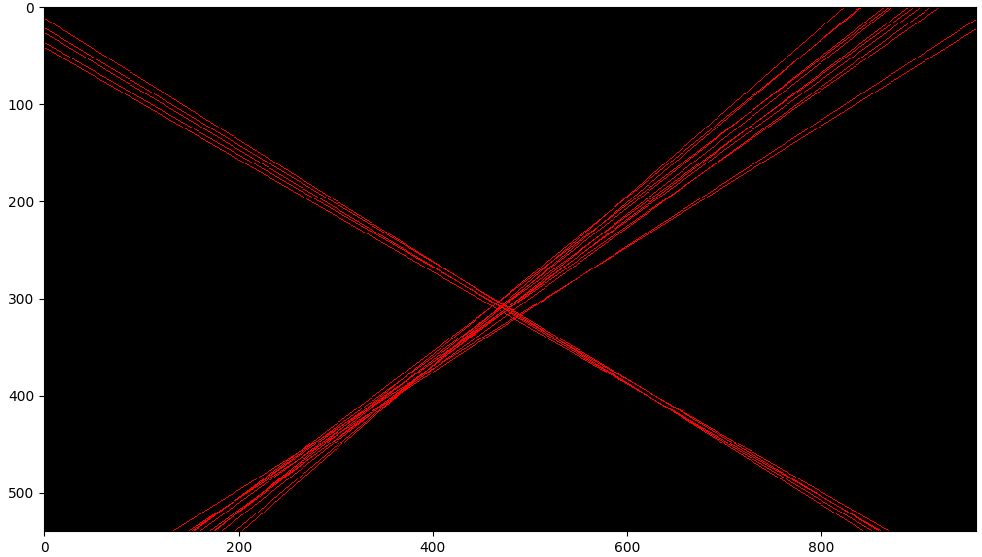

Then goes line grop detection, that accepts getLaneLines result as input parameter.

CoordinateSorter class does line groups detection and median line calculation for each found group. 
Influence it's input parameters on 'sort' function behavior could be described with help of Gherkin language:

    CoordinateSorter(max_distance_delta, max_angle_delta, threshold)

     Scenario: 'max_distance_delta' and 'max_angle_delta' parameters allow to control line group detection
       Given: 5 lines have been given to sort
         And: it is possible to create a chain 'chain_1' of lines line1, line2, line3
       Where: distance between links is less (or equal) then (max_distance_delta, max_angle_delta)
         And: it is possible to create a chain 'chain_2' of lines line4, line5
       Where: distance between links is less (or equal) then (max_distance_delta, max_angle_delta)
         And: distance between chain_1 and chain_2 edges is more than (max_distance_delta, max_angle_delta)
        Then: chain_1 and chain_2 considered as two separate lines

     Scenario: 'threshold' parameter allows to filter out noise lines
       Given: threshold = 4, set of lines
        When: sorter found 3 groups of lines
         And: the first set of lines contains 10 lines, second - 5 lines
         But: the third set of lines contains 3 lines
        Then: the third considered as noise and will not be presented in sorting result

 Resulting line is calculate as median of all lines in a group

In [5]:
class CoordinateSorter:

    def __init__(self, max_distance_delta, max_angle_delta, threshold):
        if max_angle_delta < 0:
            raise ValueError("[max_angle_delta] must be positive number")

        if max_angle_delta < 0:
            raise ValueError("[max_angle_delta] must be positive number")

        if threshold < 1 or type(threshold) != int:
            raise ValueError("[threshold] expected to be integer greater then or equal to 1")

        self._max_point_distance = (max_distance_delta, max_angle_delta)
        self._min_points_amount = threshold

    def _sortPointsByDistance(self, points_dict):
        set_list = list()

        for key, value in points_dict.items():
            indexes_set = set()
            set_list.append(indexes_set)
            indexes_set.add(key)

            for inner_key, inner_value in points_dict.items():
                point_distance = abs(np.subtract(value, inner_value))

                if point_distance[0] <= self._max_point_distance[0] \
                        and point_distance[1] <= self._max_point_distance[1]:
                    indexes_set.add(inner_key)

        return set_list

    def _splitOnGroups(self, set_list_source):

        sorted_source = list(set_list_source)
        sorted_source.sort(key=len, reverse=True)

        extremums = list()

        def find_extremums(ordered_list_of_set_items):
            if len(ordered_list_of_set_items) == 0:
                return

            first_extremum = ordered_list_of_set_items[0]
            items_for_further_sorting = list()

            for dot_set in ordered_list_of_set_items:
                if dot_set.issubset(first_extremum):
                    continue
                else:
                    if len(first_extremum.intersection(dot_set)):
                        first_extremum = first_extremum.union(dot_set)
                    else:
                        items_for_further_sorting.append(dot_set)

            extremums.append(first_extremum)
            find_extremums(items_for_further_sorting)

        find_extremums(sorted_source)

        filtered_extremums = filter(lambda x: len(x) >= self._min_points_amount, extremums)
        return filtered_extremums

    @staticmethod
    def _getMedian(source_dict, key_set):
        point_array = [source_dict[item] for item in key_set]
        data_frame = pandas.DataFrame(data=point_array, columns=["distance", "angle"])

        return data_frame["distance"].median(), data_frame["angle"].median()

    def sort(self, points_array):

        if len(points_array) < self._min_points_amount:
            return []

        points_dictionary = dict()

        for index, coordinates in enumerate(points_array):
            points_dictionary[index] = (int(coordinates[0]), coordinates[1])

        point_set_list = self._sortPointsByDistance(points_dictionary)
        point_groups = self._splitOnGroups(point_set_list)
        resulting_points = [self._getMedian(points_dictionary, point_group) for point_group in point_groups]

        return resulting_points

Result of lines sorting function in Cartesian coordinate system:

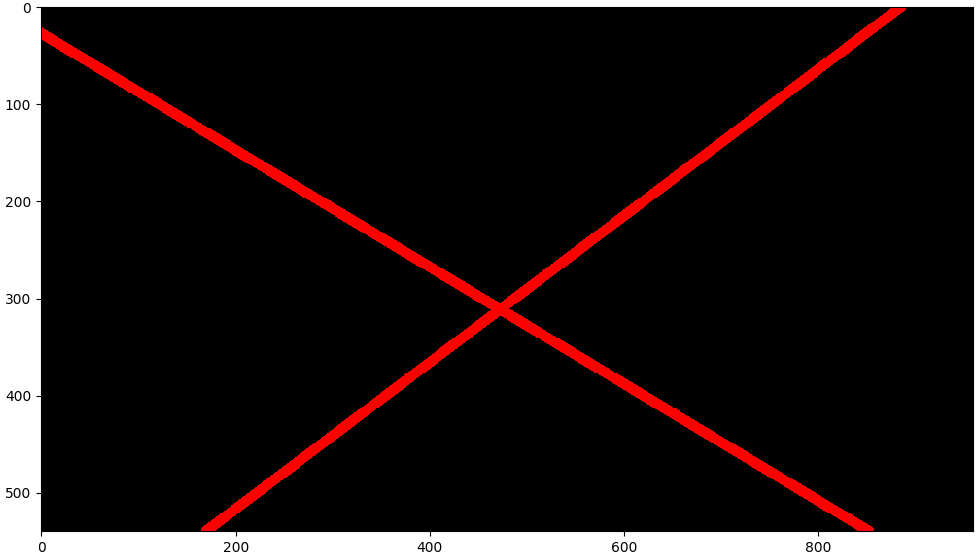

Drawing of lines with needed length:

In [6]:
def convert(rho, theta, y_min, y_max):

    def create_point(y):
        x = (rho - y*np.sin(theta))/np.cos(theta)
        return int(x), int(y)

    d1 = create_point(y_max)
    d2 = create_point(y_min)

    return d1, d2


def drawLines(polar_coordinates_array, image, color, line_weight = 10):

    y_max = image.shape[0]
    y_min = int(y_max * 2 / 3)

    lines = [convert(rho, theta, y_min, y_max) for rho, theta in polar_coordinates_array]

    for d1, d2 in lines:
        cv2.line(image, d1, d2, color, line_weight)

The result:

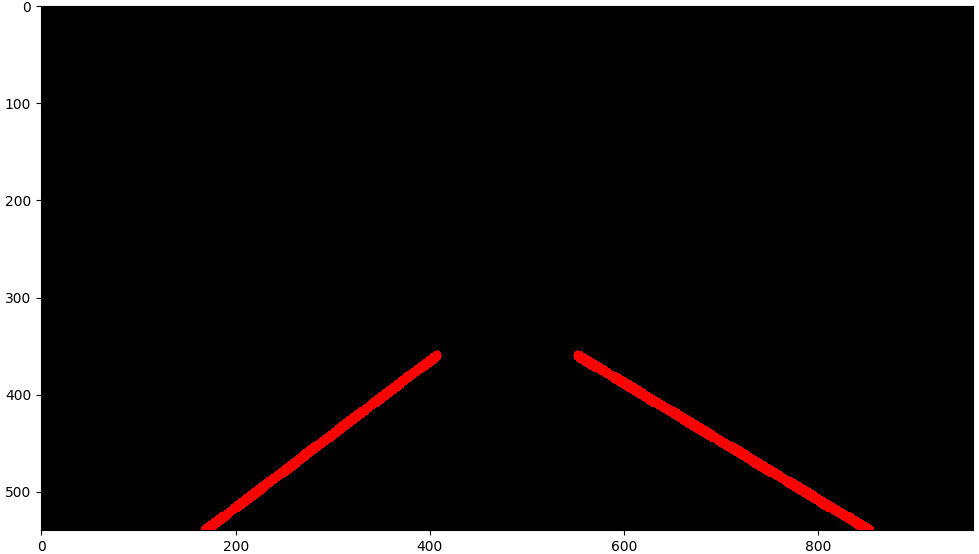

The pipeline itself:

In [7]:
class ImageProcessor:

    def __init__(self, detection_area_filter, coordinate_sorter):
        self._bgr_line_color = (0, 0, 255)
        self._detection_area_filter = detection_area_filter
        self._coordinate_sorter = coordinate_sorter

    def processFrame(self, bgr_frame):
        frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2HSV)

        bw_color_mask = self._detection_area_filter.getColorMask(frame)
        bw_area = self._detection_area_filter.applyDetectionArea(bw_color_mask)

        bw_edges = getEdges(bw_area)

        polar_lane_coordinates = getLaneLines(bw_edges)
        average_polar_lane_coordinates = self._coordinate_sorter.sort(polar_lane_coordinates)

        lines_image = np.zeros(bgr_frame.shape, dtype=np.uint8)
        drawLines(average_polar_lane_coordinates, lines_image, self._bgr_line_color)

        result_image = cv2.addWeighted(lines_image, 0.9, bgr_frame, 1, 0)

        return result_image

    def _convert_bw_2_color(self, bw_image):
        return np.dstack((bw_image, bw_image, bw_image))

And the result of processFrame:

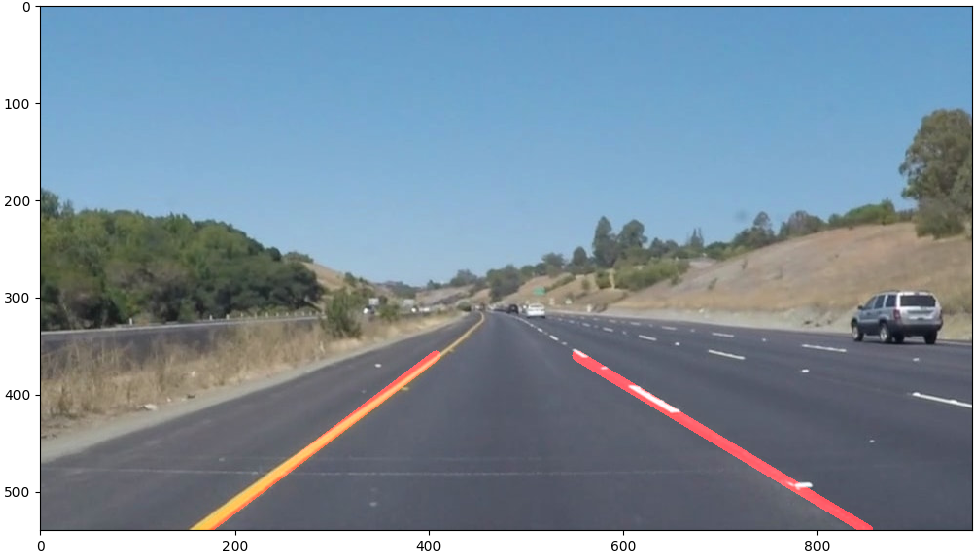

RGB image processing entry point

In [8]:
def showImage(file_path):
    def convert(image):
        return image[..., [2, 1, 0]]

    image_path = getPathFor(file_path)
    rgb_image = mpimg.imread(image_path)

    bgr_frame = convert(rgb_image)
    frame = img_processor.processFrame(bgr_frame)
    rgb_frame = convert(frame)

    plt.imshow(rgb_frame)
    plt.show()

Video processing entry point

In [9]:
def playVideo(file_path):
    video_path = getPathFor(file_path)
    video = cv2.VideoCapture(video_path)
    print("About to start video playback...")
    
    while video.isOpened():        
        _, bgr_frame = video.read()

        if not isinstance(bgr_frame, np.ndarray):
            # workaround to handle end of video stream. 
            break
        
        frame = img_processor.processFrame(bgr_frame)
        cv2.imshow("output", frame)
        
        key = cv2.waitKey(1) & 0xFF
        # stop video on ESC key pressed
        if key == 27:
            break
            
    print("Video has been closed successfully.")
    video.release()
    cv2.destroyAllWindows()

Constants with image/video pathes for testing, pipeline initialization

About to open file: E:\personal\std\car\Lane detection\imageprocessor\input/test_images/solidYellowCurve2.jpg



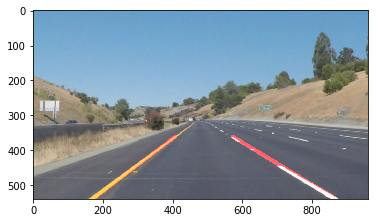

In [13]:
image1 = "input/test_images/solidWhiteCurve.jpg"
image2 = "input/test_images/solidWhiteRight.jpg"
image3 = "input/test_images/solidYellowCurve.jpg"
image4 = "input/test_images/solidYellowCurve2.jpg"
image5 = "input/test_images/solidYellowLeft.jpg"
image6 = "input/test_images/whiteCarLaneSwitch.jpg"

video1 = "input/test_videos/challenge.mp4"
video2 = "input/test_videos/solidYellowLeft.mp4"
video3 = "input/test_videos/solidWhiteRight.mp4"    

detection_area_filter = DetectionAreaFilter()

max_distance_delta = 40  # max distance between lines (rho1 - rho2) in polar coordinate system
max_angle_delta = np.radians(4)  # max angle between lines (theta1 - theta2) in polar coordinate system
threshold = 3  # min amount of lines in set filter
coordinate_sorter = CoordinateSorter(max_distance_delta, max_angle_delta, threshold)

img_processor = ImageProcessor(detection_area_filter, coordinate_sorter)

showImage(image4)
#playVideo(video1)